# Harmonic oscillators

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ June 7, 2023

This notebook tests how to expand Woods-Saxon radial wave functions in spherical harmonic oscillator wave functions.

_Last update:_ October 9, 2023

In [1]:
# Python imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.special import (
    factorial, factorial2, genlaguerre, sph_harm, spherical_jn
)
from sympy.physics.quantum.cg import CG

In [2]:
# Imports from scripts
from scripts.figures import set_rc_parameters, label_nlj_state, label_nucleus
from scripts.integration import momentum_mesh

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
def compute_clebsch_gordan_table(j_max):
    """
    Calculate Clebsch-Gordan coefficients for combinations of j and m_j up
    to j_max.
    
    Parameters
    ----------
    j_max : int
        Maximum j value for j_1, j_2, and j_3. This also constrains m_j.
    
    Returns
    -------
    cg_table : dict
        Table of Clebsch-Gordan coefficients <j_1 m_j_1 j_2 m_j_2|j_3 m_j_3>
        for each combination of angular momenta.
        
    """
        
    cg_table = {}
        
    j_array = np.arange(0, j_max+1/2, 1/2)
    
    for j_1 in j_array:
        for j_2 in j_array:
            j_3_array = np.arange(abs(j_1-j_2), j_1+j_2+1)
            for j_3 in j_3_array:
                for m_1 in np.arange(-j_1, j_1+1, 1):
                    for m_2 in np.arange(-j_2, j_2+1, 1):
                        
                        m_3 = m_1 + m_2
                        
                        if abs(m_3) <= j_3:
                            cg_table[(j_1, m_1, j_2, m_2, j_3, m_3)] = float(
                                CG(j_1, m_1, j_2, m_2, j_3, m_3).doit()
                            )
                            
    print(f"Done calculating Clebsch-Gordan table up to j_max = {j_max}.")
                                
    return cg_table

In [5]:
# Set table of Clebsch-Gordan coefficients
jmax = 3
cg_table = compute_clebsch_gordan_table(jmax)

Done calculating Clebsch-Gordan table up to j_max = 3.


## Harmonic oscillator wavefunctions in coordinate space

$$
\psi_{nlm}(\mathbf{r}) = R_{nl}(r) Y_{lm}(\hat{r})
$$

$$
R_{nl}(r) = \sqrt{\frac{\nu^{3/2} 2^{n+l+2} n!}{\pi^{1/2} (2l+2n+1)!!}}
(\nu r^2)^{l/2} L_n^{l+1/2}(\nu r^2) e^{-\nu r^2/2}
$$

In [6]:
class SingleParticleState:
    """
    Single-particle state class. Packs together the following single-particle
    quantum numbers into one object.
    
    Parameters
    ----------
    n : int
        Principal quantum number n = 1, 2, ...
    l : int
        Orbital angular momentum l = 0, 1, ...
    j : float
        Total angular momentum j = 1/2, 3/2, ...
    m_j : float
        Total angular momentum projection m_j = -j, -j+1, ..., j.
    m_t : float
        Isospin projection m_t = 1/2 or -1/2.
    
    """
    
    
    def __init__(self, n, l, j, m_j, m_t):
        
        # Check if m_j is valid
        if abs(m_j) > j:
            raise RuntimeError("m_j is not valid.")
            
        # Check that |m_t| = 1/2
        if abs(m_t) != 1/2:
            raise RuntimeError("m_t is not valid.")
            
        self.n = n
        self.l = l
        self.j = j
        self.m_j = m_j
        self.m_t = m_t
        
        if m_t == 1/2:
            self.nucleon = 'proton'
        elif m_t == -1/2:
            self.nucleon = 'neutron'
        
        
    def __eq__(self, sp_state):

        if (
            self.n == sp_state.n and self.l == sp_state.l
            and self.j == sp_state.j and self.m_j == sp_state.m_j
            and self.m_t == sp_state.m_t
        ):
            
            return True
        
        else:
            
            return False
        
        
    def __str__(self):
        
        # Spectroscopic notation of orbital angular momentum
        l_str = convert_l_to_string(self.l)  # E.g., 's', 'p', 'd', ...
        
        # Display j subscript as a fraction
        numerator = 2*int(self.j) + 1
        denominator = 2

        return fr"${self.n}{l_str}_{{{numerator}/{denominator}}}$"

In [7]:
class WoodsSaxon:
    """
    Woods-Saxon orbitals class. Handles the radial wave functions associated
    with the Woods-Saxon potential from the subroutine in woodsaxon.f90. Outputs
    radial functions in coordinate and momentum space.
    
    Parameters
    ----------
    nucleus_name : str
        Name of the nucleus (e.g., 'O16', 'Ca40', etc.)
    Z : int
        Proton number of the nucleus.
    N : int
        Neutron number of the nucleus.
    run_woods_saxon : bool, optional
        Option to run the Woods-Saxon subroutine to generate orbital files.
    n_max : int, optional
        Maximum principal quantum number where n = 1, 2, ..., n_max.
    l_max : int, optional
        Maximum orbital angular momentum where l = 0, 1, ..., l_max.
    rmax : float, optional
        Maximum r for orbital tables.
    ntab : int, optional
        Number of points for orbital tables.
        
    """
    
    
    def __init__(self, nucleus_name, Z, N, cg_table, rmax=40, ntab=2000,
                 kmax=10.0, kmid=2.0, ntot=120, com_correction=False):
        
        # Set instance attributes
        self.woods_saxon_directory = f"../data/woods_saxon/{nucleus_name}/"
        self.cg_table = cg_table
        self.A = int(Z + N)

        # Order single-particle states with lowest energy first
        self.order_sp_states(Z, N)
        
        # Organize wave functions in dictionary
        self.sp_wfs = {}
        for sp_state in self.sp_states:
            
            # Wave functions are independent of m_j, so fix m_j=j
            if sp_state.m_j == sp_state.j:
                
                file_name = self.get_orbital_file_name(sp_state)
 
                data = np.loadtxt(self.woods_saxon_directory + file_name)
                
                # Use n, l, j, m_t as the key
                key = (sp_state.n, sp_state.l, sp_state.j, sp_state.m_t)
                self.sp_wfs[key] = data[:, 1]
                
        # r_array and dr are the same for every s.p. state
        self.r_array = data[:, 0]
        self.dr = max(self.r_array) / len(self.r_array)
        
        # Interpolate occupied s.p. wave functions w.r.t. momentum k
        self.interpolate_wavefunctions(kmax, kmid, ntot, com_correction)
        
        
    def get_orbital_file_name(self, sp_state):
        """Returns the file name of the orbital."""
            
        # Proton
        if sp_state.m_t == 1/2:
            file_name = (f"p.n{int(sp_state.n-1)}.l{int(sp_state.l)}"
                         f".j{int(2*sp_state.j)}.orb")
        # Neutron
        elif sp_state.m_t == -1/2:
            file_name = (f"n.n{int(sp_state.n-1)}.l{int(sp_state.l)}"
                         f".j{int(2*sp_state.j)}.orb")
            
        return file_name
        
        
    def order_sp_states(self, Z, N):
        """Keep track of all s.p. states and occupied s.p. states"""

        self.sp_states = []  # All single-particle states
        self.occupied_states = []  # Occupied single-particle states < E_F
        proton_count = 0
        neutron_count = 0
        
        # File with details of the orbitals
        ws_file = self.woods_saxon_directory + "ws_log"
    
        # Order single-particle states using the ws_log file
        with open(ws_file, 'r') as f:
            for line in f:
                unit = line.strip().split()
                
                # Protons
                if len(unit) > 0 and unit[0] == '1':

                    j = int(unit[3])/2
                    for m_j in np.arange(-j, j+1, 1):
                        sp_state = SingleParticleState(
                            int(unit[1])+1, int(unit[2]), j, m_j, 1/2
                        )  # n, l, j, m_j, m_t
                    
                        self.sp_states.append(sp_state)
                    
                        if proton_count < Z:
                            self.occupied_states.append(sp_state)
                            # Add up filled proton states
                            proton_count += 1
                    
                
                # Neutrons
                elif len(unit) > 0 and unit[0] == '2':

                    j = int(unit[3])/2
                    for m_j in np.arange(-j, j+1, 1):
                        sp_state = SingleParticleState(
                            int(unit[1])+1, int(unit[2]), j, m_j, -1/2
                        )  # n, l, j, m_j, m_t
                    
                        self.sp_states.append(sp_state)
                    
                        if neutron_count < N:
                            self.occupied_states.append(sp_state)
                            # Add up filled neutron states
                            neutron_count += 1


    def get_wf_rspace(
            self, sp_state, print_normalization=False, com_correction=False
    ):
        """Single-particle wave function in coordinate space."""
        
        # n, l, j, m_t
        key = (sp_state.n, sp_state.l, sp_state.j, sp_state.m_t) 
        u_array = self.sp_wfs[key]

        # Normalization: \int dr |u(r)|^2 = 1
        if print_normalization:
            normalization = np.sum(self.dr * u_array ** 2)
            print(f"Coordinate space normalization = {normalization}.")
        
        # Return r and [(A-1)/A]^(1/4) * u(\sqrt[(A-1)/A] * r)
        if com_correction:
            
            u_func = InterpolatedUnivariateSpline(self.r_array, u_array)
            scaling = ((self.A-1)/self.A) ** (1/4)
            # scaling = np.sqrt((self.A-1)/self.A)
            u_com_array = np.sqrt(scaling) * u_func(scaling * self.r_array)

            return self.r_array, u_com_array
        
        # Return r and u(r)
        else:

            return self.r_array, u_array
    
    
    def fourier_transformation(self, l, r_array, k_array):
        """Fourier transformation matrix for given orbital angular momentum."""
        
        # r_array column vectors and k_array row vectors where both grids are
        # n x m matrices
        r_cols, k_rows = np.meshgrid(r_array, k_array)
        
        # Transformation matrix with shape n x m, where m is the length of
        # r_array and n is the length of the k_array
        M = 1j ** (-l) * np.sqrt(2/np.pi) * self.dr * r_cols * spherical_jn(
            l, k_rows*r_cols
        )
        
        return M
    
    
    def get_wf_kspace(
            self, sp_state, kmax, kmid, ntot, print_normalization=False,
            interpolate=False, com_correction=False
    ):
        """Single-particle wave function in momentum space."""
    
        # Set momentum mesh with more points at low momentum
        k_array, k_weights = momentum_mesh(kmax, kmid, ntot)
    
        # Get coordinate-space s.p. wave function
        r_array, u_array = self.get_wf_rspace(sp_state,
                                              com_correction=com_correction)

        # Fourier-transform the wave function to momentum space
        phi_array = (self.fourier_transformation(sp_state.l, r_array, k_array)
                     @ u_array)
    
        # Normalization: \int dk k^2 |\phi(k)|^2 = 1
        if print_normalization:
            normalization = np.sum(k_weights * k_array ** 2
                                   * abs(phi_array) ** 2)
            print(f"Momentum space normalization = {normalization}.")
            
        # Interpolate and return function?
        if interpolate:
            
            if sp_state.l % 2 == 0:  # Even l
                
                phi_func = InterpolatedUnivariateSpline(k_array, phi_array.real)
                
            else:  # Odd l
            
                phi_func = InterpolatedUnivariateSpline(k_array, phi_array.imag)
                
            return phi_func
        
        # Otherwise return momentum, weights, and \phi(k)
        else:
            return k_array, k_weights, phi_array
        
        
    def interpolate_wavefunctions(self, kmax, kmid, ntot, com_correction=False):
        """Create dictionary of \phi(k) interpolated functions where the key
        is the single-particle state.
        """
        
        # Organize interpolated wave functions in dictionary with s.p. quantum
        # numbers as the key
        self.phi_functions = {}
        
        for sp_state in self.occupied_states:
            
            key = (sp_state.n, sp_state.l, sp_state.j, sp_state.m_t)
            self.phi_functions[key] = self.get_wf_kspace(
                sp_state, kmax, kmid, ntot, interpolate=True,
                com_correction=com_correction
            )
            
    
    def psi(self, sp_state, k, theta, phi, sigma, tau):
        """Single-particle wave function \psi_\alpha(k_vector; \sigma, \tau)."""

        # Calculate \phi_\alpha(k)
        key = (sp_state.n, sp_state.l, sp_state.j, sp_state.m_t)
        if sp_state.l % 2 == 0:  # Even l
            phi_sp_wf = self.phi_functions[key](k)
        else:  # Odd l needs factor of i^-l
            phi_sp_wf = 1j ** (-sp_state.l) * self.phi_functions[key](k)
    
        # Calculate spinor spherical harmonic
        Y_jml = self.spinor_spherical_harmonic(sp_state.l, sp_state.j,
                                               sp_state.m_j, theta, phi, sigma)
    
        # Isospinor indexed by \tau \chi_{m_t}(\tau)
        chi_tau = kronecker_delta(tau, sp_state.m_t)

        return phi_sp_wf * Y_jml * chi_tau
    

    def spinor_spherical_harmonic(self, l, j, m_j, theta, phi, sigma):
        """Spinor spherical harmonic for a s.p. state described by the quantum
        numbers j, m_j, l, and s=1/2.
        """
        
        # Spinor indexed by \sigma \eta_{m_s}^(\sigma) = \delta_{m_s, \sigma}
        m_s = sigma
    
        # m_l must be fixed since m_j and m_s are determined
        m_l = m_j - m_s
        
        # Check that |m_l| <= l
        if np.abs(m_l) <= l:
        
            # Clebsch-Gordan coefficient for l-s coupling
            cg = self.cg_table[(l, m_l, 1/2, m_s, j, m_j)]
        
            # Spherical harmonic
            Y_lm = sph_harm(m_l, l, phi, theta)
            
            return cg * Y_lm
        
        else:
            
            return 0+0j

In [8]:
class HarmonicOscillator:
    
    # Mass of the nucleon in MeV
    m = (939.565 + 938.272) / 2
    
    # \hbar c in Mev fm
    hbarc = 197.326  
    
    def __init__(self, A, scale_b=False):
        
        # Set instance attributes
        self.hbar_omega = 45 / (A ** (1/3)) - 25 / (A ** (2/3))  # MeV
        b = np.sqrt(self.hbarc ** 2 / self.hbar_omega / self.m)
        if scale_b:  # C.o.M. correction
            b *= np.sqrt(A/(A-1))
        self.nu = 1 / b ** 2  # fm^-2
        # self.nu = self.hbar_omega * self.m / self.hbarc ** 2  # fm^-2
    
    def radial_normalization_factor(self, n, l):
        """Normalization of R_nl(r). Units are fm^-3/2."""
    
        numerator = self.nu ** (3/2) * 2 ** (n+l+2) * factorial(n)
        denominator = np.sqrt(np.pi) * factorial2(2*n+2*l+1)
    
        return np.sqrt(numerator / denominator)
    
    def R_nl(self, r, n, l):
        """Radial wavefunction of the spherical harmonic oscillator in
        coordinate space.
        """
    
        factor = self.radial_normalization_factor(n, l)
        laguerre_polynomial = genlaguerre(n, l+1/2)
        xi = self.nu * r ** 2  # Unitless
    
        return factor * xi ** (l/2) * laguerre_polynomial(xi) * np.exp(-xi/2)
    
    def psi(self, r, theta, phi, n, l, m):
        """Spherical harmonic oscillator wavefunction in coordinate space."""
    
        return self.R_nl(r, l, n) * sph_harm(m, l, phi, theta)

In [9]:
rmax, dr = 10.0, 0.1
r_array = np.arange(0.0, rmax, dr)

In [10]:
# Test normalization of harmonic oscillator wavefunctions given A=16
A = 16
harmonic_oscillator = HarmonicOscillator(A)

# Normalization of R_nl(r) for n, l = 0, 0
n, l = 0, 0
R_nl_array = harmonic_oscillator.R_nl(r_array, n, l)
norm = np.sum(dr * r_array ** 2 * np.abs(R_nl_array) ** 2)
print(f"n={n}, l={l}, normalization={norm}")

# Normalization of R_nl(r) for n, l = 1, 1
n, l = 3, 1
R_nl_array = harmonic_oscillator.R_nl(r_array, n, l)
norm = np.sum(dr * r_array ** 2 * np.abs(R_nl_array) ** 2)
print(f"n={n}, l={l}, normalization={norm}")

# Normalization of R_nl(r) for n, l = 0, 2
n, l = 0, 2
R_nl_array = harmonic_oscillator.R_nl(r_array, n, l)
norm = np.sum(dr * r_array ** 2 * np.abs(R_nl_array) ** 2)
print(f"n={n}, l={l}, normalization={norm}")

# Are R_nl(r) orthogonal in n and n'? -> Yes
R_nl_array = harmonic_oscillator.R_nl(r_array, 0, 1)
R_npl_array = harmonic_oscillator.R_nl(r_array, 1, 1)
norm = np.sum(dr * r_array ** 2 * np.conj(R_nl_array) * R_npl_array)
print(f"Integral = {norm}")

n=0, l=0, normalization=0.999999999999976
n=3, l=1, normalization=0.9999983934221249
n=0, l=2, normalization=0.9999999999924951
Integral = 1.1001384931112039e-11


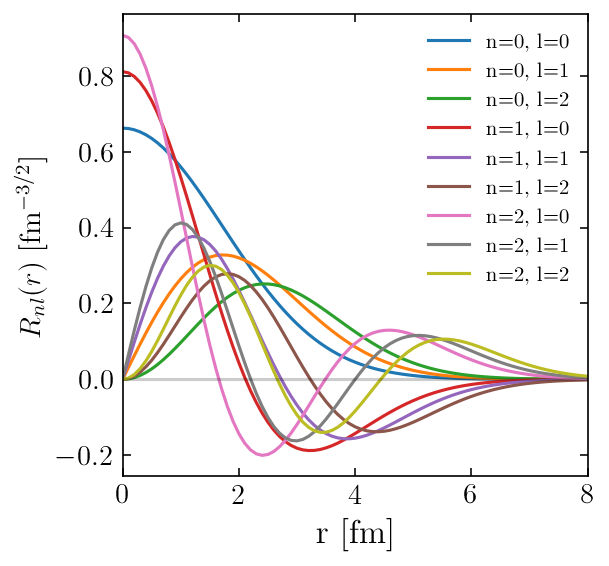

In [11]:
# Plot radial part

# Initialize figure
plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))

for n in range(3):
    for l in range(3):
        
        R_nl_array = harmonic_oscillator.R_nl(r_array, n, l)
        
        ax.plot(r_array, R_nl_array, label=f"n={n}, l={l}")
        
ax.axhline(y=0.0, alpha=0.2, color='black')
        
# Set axes limits
ax.set_xlim(0,8)

# Set axes labels
ax.set_xlabel("r [fm]", fontsize=16)
ax.set_ylabel(r"$R_{nl}(r)$ [fm$^{-3/2}$]")

# Set legend
ax.legend(loc='upper right', fontsize=10, frameon=False)

plt.show()

## Expansion of Woods-Saxon $\frac{u_{nlj}(r)}{r}$ in terms of harmonic oscillator wavefunctions

$$
\frac{u_{n l j m_t}(r)}{r} = \sum_{n'} C_{n' l j m_t} R_{n'l}(r)
$$

$$
C_{n l j m_t} = \int_0^\infty dr r \, u_{n l j  m_t}(r) R^*_{n l}(r)
$$

In [12]:
class WoodsSaxonExpansion:
    
    def __init__(self, woods_saxon, harmonic_oscillator):
        
        self.woods_saxon = woods_saxon
        self.harmonic_oscillator = harmonic_oscillator
    
    def R_nlj(self, r, n, l, j, m_t, n_max=4):
        """Expansion of Woods-Saxon radial wavefunction u(r)/r."""
        
        # TESTING
        C_array = np.zeros(n_max+1)
        R_array = np.zeros_like(r)
        
        # To-do: Vectorize this w.r.t. n'
        for nprime in range(0, n_max+1):
        
            # Overlap coefficient
            # C = self.overlap(nprime, n, l, j, m_t)
            # TESTING
            C_array[nprime] = self.overlap(nprime, n, l, j, m_t)
            
            # TESTING
            # print(f"n'={nprime}, C={C}")
        
            # Radial harmonic oscillator wavefunctions
            R_npl = self.harmonic_oscillator.R_nl(r, nprime, l)
            
            # R_array += C * R_npl
            # TESTING
            R_array += C_array[nprime] * R_npl
            
        # return R_array
        # TESTING
        return C_array, R_array
    
    def overlap(self, nprime, n, l, j, m_t):
        """Overlap coefficient between the Woods-Saxon and spherical harmonic
        oscillator radial wavefunctions.
        """

        # u_{n l j m_t}(r) from Woods-Saxon class
        sp_state = SingleParticleState(n, l, j, j, m_t)
        r_array, u_nlj_array = self.woods_saxon.get_wf_rspace(sp_state)
        
        # R_{n' l}(r) from harmonic oscillator class
        R_nl_array = self.harmonic_oscillator.R_nl(r_array, nprime, l)
        
        # C = dr * np.sum(r_array * u_nlj_array * np.conj(R_nl_array))
        C = np.trapz(r_array * u_nlj_array * np.conj(R_nl_array), r_array)
        
        return C

In [13]:
# nucleus_name, Z, N = 'O16', 8, 8
nucleus_name, Z, N = 'He4', 2, 2
A = Z + N

# Single-particle state
n, l, j, m_t = 1, 0, 1/2, 1/2  # 1s_{1/2}
# n, l, j, m_t = 1, 1, 3/2, 1/2  # 1p_{3/2}
# n, l, j, m_t = 1, 1, 1/2, 1/2  # 1p_{1/2}

In [14]:
# Test normalization of harmonic oscillator wavefunctions
woods_saxon = WoodsSaxon(nucleus_name, Z, N, cg_table, rmax=40, ntab=2000)
harmonic_oscillator = HarmonicOscillator(A)
wse = WoodsSaxonExpansion(woods_saxon, harmonic_oscillator)

sp_state = SingleParticleState(n, l, j, j, m_t)
r_array, u_nlj_array = woods_saxon.get_wf_rspace(sp_state)

# n = 1, l = 1, j = 1/2
# radial_wf_array = wse.R_nlj(r_array, n, l, j, m_t)
# TESTING
C_array, radial_wf_array = wse.R_nlj(r_array, n, l, j, m_t)

Harmonic oscillator normalization = 0.9999657437336271.
Woods-Saxon normalization = 0.9999970019626417.


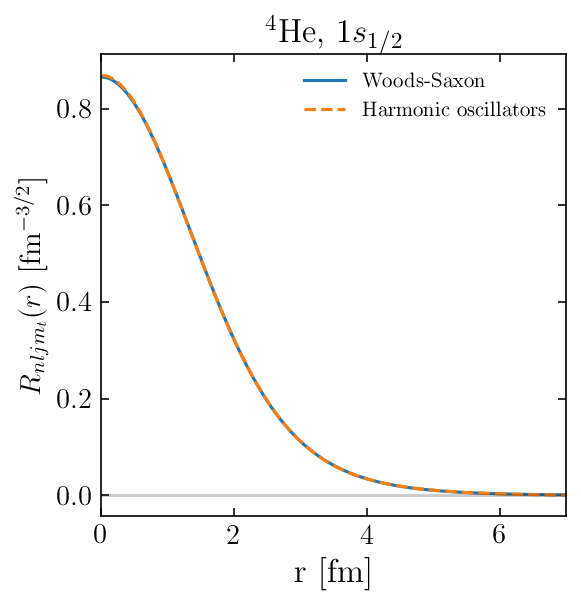

In [15]:
# Compare original Woods-Saxon 1p_{1/2} state to expansion

# Initialize figure
plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))

ax.plot(r_array, u_nlj_array / r_array, label="Woods-Saxon")
ax.plot(r_array, radial_wf_array, label="Harmonic oscillators",
        linestyle='dashed')
ax.axhline(y=0.0, alpha=0.2, color='black')

# Print normalizations?
ho_norm = np.trapz(r_array ** 2 * np.abs(radial_wf_array) ** 2, r_array)
ws_norm = np.trapz(np.abs(u_nlj_array) ** 2, r_array)
print(f"Harmonic oscillator normalization = {ho_norm}.")
print(f"Woods-Saxon normalization = {ws_norm}.")
        
# Set axes limits
ax.set_xlim((0, 7))

# Set axes labels
ax.set_xlabel("r [fm]", fontsize=16)
ax.set_ylabel(r"$R_{n l j m_t}(r)$ [fm$^{-3/2}$]")

# Set legend
ax.legend(loc='upper right', fontsize=10, frameon=False)

# Set title
title = label_nucleus(nucleus_name) + ', ' + label_nlj_state(n, l, j)
ax.set_title(title, fontsize=16)

plt.show()

In [16]:
# Make correction by scaling r -> [(A-1)/A]^{1/4} * r in Woods-Saxon and
# b -> \sqrt[A/(A-1)] * b in harmonic oscillator expansion of Woods-Saxon

woods_saxon_scaled = WoodsSaxon(nucleus_name, Z, N, cg_table, rmax=40,
                                ntab=2000, com_correction=True)
harmonic_oscillator_scaled = HarmonicOscillator(A, scale_b=True)

sp_state = SingleParticleState(n, l, j, j, m_t)
r_array, u_nlj_array_scaled = woods_saxon_scaled.get_wf_rspace(
    sp_state, com_correction=True)

# n = 1, l = 1, j = 1/2
radial_wf_array_scaled = np.zeros_like(r_array)
n_max = 4
for nprime in range(0, n_max+1):
        
    # SCALED radial harmonic oscillator wavefunctions
    R_npl = harmonic_oscillator_scaled.R_nl(r_array, nprime, l)
    
    radial_wf_array_scaled += C_array[nprime] * R_npl

Harmonic oscillator normalization = 0.9999668025333546.
Woods-Saxon normalization = 0.9999975833840385.


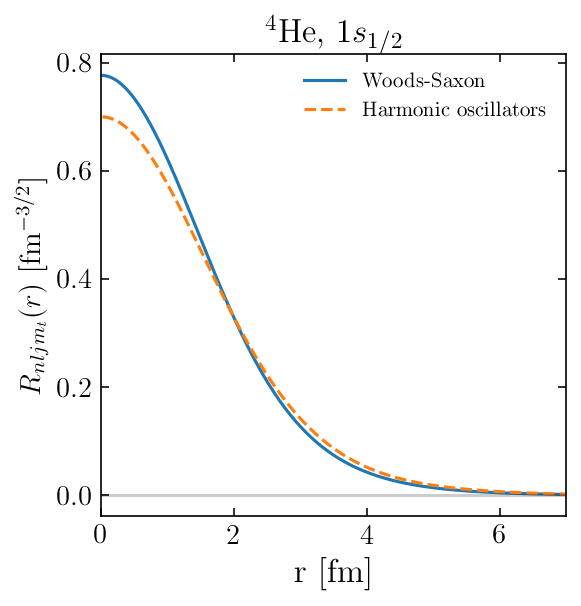

In [17]:
# Compare original scaled versions

# Initialize figure
plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))

ax.plot(r_array, u_nlj_array_scaled / r_array, label="Woods-Saxon")
ax.plot(r_array, radial_wf_array_scaled, label="Harmonic oscillators",
        linestyle='dashed')
ax.axhline(y=0.0, alpha=0.2, color='black')

# Print normalizations?
ho_norm = np.trapz(r_array ** 2 * np.abs(radial_wf_array_scaled) ** 2, r_array)
ws_norm = np.trapz(np.abs(u_nlj_array_scaled) ** 2, r_array)
print(f"Harmonic oscillator normalization = {ho_norm}.")
print(f"Woods-Saxon normalization = {ws_norm}.")
        
# Set axes limits
ax.set_xlim((0, 7))

# Set axes labels
ax.set_xlabel("r [fm]", fontsize=16)
ax.set_ylabel(r"$R_{n l j m_t}(r)$ [fm$^{-3/2}$]")

# Set legend
ax.legend(loc='upper right', fontsize=10, frameon=False)

# Set title
title = label_nucleus(nucleus_name) + ', ' + label_nlj_state(n, l, j)
ax.set_title(title, fontsize=16)

plt.show()

In [18]:
print(C_array)

[ 0.99775213 -0.01319663  0.06365614 -0.01273852  0.00842217]
